We will perform sentiment analysis with IMDb. The workflow is as follows:
1. EDA & cleaning
2. Baseline linear model
3. LSTM model

In [4]:
# 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import collections
import itertools
import os

In [4]:
reviews_train = []
for line in open(os.getcwd() + '/data/imbd_train.txt', 'r', encoding='latin1'):
    
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open(os.getcwd() + '/data/imbd_test.txt', 'r', encoding='latin1'):
    
    reviews_test.append(line.strip())

In [5]:
target = ["positive" if i < 12500 else "negative" for i in range(25000)]

In [6]:
df1 = pd.DataFrame({"review": reviews_train, "sentiment":target})
df2 = pd.DataFrame({"review": reviews_test, "sentiment":target})

In [7]:
df = pd.concat([df1, df2]).sample(frac=1.0, random_state=42).reset_index(drop=True)

In [8]:
df

,review,sentiment
0,"When I first saw the ad for this, I was like '...",positive
1,"""A Girl's Folly"" is a sort of half-comedy, hal...",positive
2,I started watching the show from the first sea...,positive
3,This is a more interesting than usual porn mov...,positive
4,I suppose for 1961 this film was supposed to b...,negative
...,...,...
49995,I saw this movie at midnight on On Demand the ...,positive
49996,"Some aspects of this production are good, such...",negative
49997,I was not old enough to really appreciate the ...,negative
49998,Nice movie with a great soundtrack which spans...,positive


# 1. EDA & cleaning

<Axes: xlabel='count', ylabel='sentiment'>

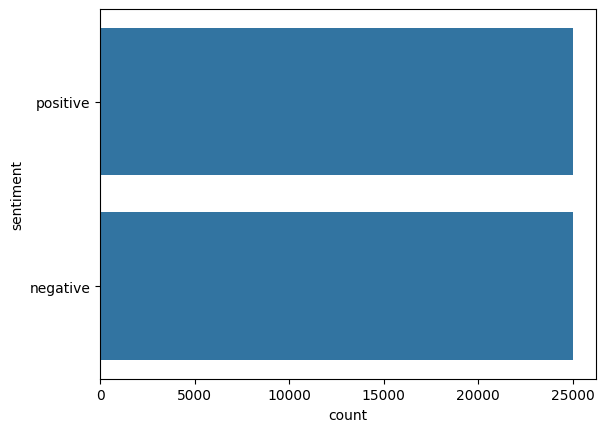

In [9]:
sns.countplot(df["sentiment"])

In [10]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

There is no null data.

### Text cleaning

In [11]:
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    return ' '.join(x.lower() for x in texts.split())

In [12]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

# 2. Baseline linear model

Before we build time-consuming neural network model, simple classifier is tried.
Tfidf method is used for text vectorization.

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      6238
           1       0.89      0.90      0.89      6262

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



<Axes: >

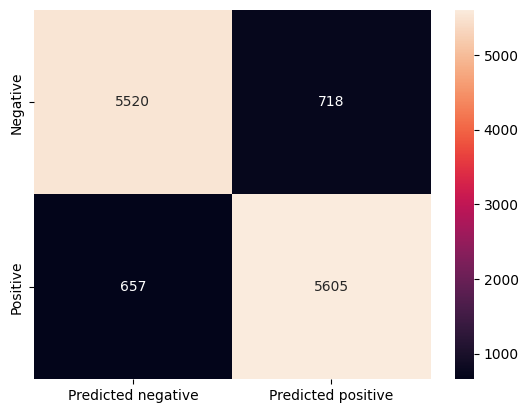

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'].map({'negative':0, 'positive':1}))
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr_clf', LogisticRegression())])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

Logistic regression provides 90% accuracy for test set, which is fast and adapted for such large datasets.

# 3. LSTM model

To quickly explore LSTM model, we firstly take only 500 characters. That is much faster way than taking full sentences.

In [14]:
df['review_cleaned_500'] = df['review_cleaned'].apply(lambda x:x[:500])

df['review_cleaned_500'][2]

'i started watching the show from the first season and at the beginning i was pretty skeptical about it original movie was kind of childish and i was just looking for some sci fi show while waiting for the bsg new season but after few episodes i became a fan i ve loved the characters the not so stupid as you think he is jack o neill the not only smart samantha carter the glorious teal c women and kids favorite and brilliant dr daniel jackson of course stories sometimes not serious sometimes even '

### Tokenize & Padding

Let's convert tokens to ID. We will use keras Tokenizer which can filter punctuations and take only most-counted 10000 words.

In [15]:
tokenizer = Tokenizer(num_words=7000)

In [16]:
tokenizer.fit_on_texts(df['review_cleaned_500'])
seq = tokenizer.texts_to_sequences(df['review_cleaned_500'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (50000, 116), X_min: 0, X_max: 6999


Sentiment is converted to 0 (negative) or 1 (positive).

In [17]:
y = df['sentiment'].map({'negative' : 0, 'positive' : 1}).values

Let's build the simple LSTM model using first 500 characters datasets.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40000, 116) (10000, 116) (40000,) (10000,)


In [27]:
y_train

array([1, 0, 0, ..., 0, 1, 1])

In [35]:
embed_size = 100
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=7000, output_dim=embed_size, input_shape=[None], mask_zero=True),
  
    # keras.layers.LSTM(50, input_shape=(116,1)),
    keras.layers.LSTM(30, dropout=0.4, recurrent_dropout=0.4, return_sequences=True),
    keras.layers.LSTM(30, dropout=0.4, recurrent_dropout=0.4,),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, None, 100)      │       700,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, None, 30)       │        15,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 723,071 (2.76 MB)

 Trainable params: 723,071 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
optimizer =keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1)

Epoch 1/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.6291 - loss: 0.6401 - val_accuracy: 0.8020 - val_loss: 0.4525
Epoch 2/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 69s 61ms/step - accuracy: 0.8022 - loss: 0.4632 - val_accuracy: 0.8073 - val_loss: 0.4345
Epoch 3/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - accuracy: 0.8196 - loss: 0.4263 - val_accuracy: 0.7993 - val_loss: 0.4405
Epoch 4/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.8357 - loss: 0.3960 - val_accuracy: 0.7918 - val_loss: 0.4566
Epoch 5/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.8443 - loss: 0.3784 - val_accuracy: 0.7905 - val_loss: 0.4615
Epoch 6/20
 462/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.8554 - loss: 0.3619

KeyboardInterrupt: 

In [36]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    mode='auto',
    min_delta=0.0001,
    cooldown=0
)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.1)[2]

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)


model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1,
                    callbacks = [reduce_lr, lr_scheduler])


Epoch 1/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 119s 103ms/step - accuracy: 0.6758 - loss: 0.5921 - val_accuracy: 0.7725 - val_loss: 0.4922 - learning_rate: 0.0010
Epoch 2/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 138s 100ms/step - accuracy: 0.8009 - loss: 0.4525 - val_accuracy: 0.8005 - val_loss: 0.4458 - learning_rate: 0.0010
Epoch 3/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 122s 109ms/step - accuracy: 0.8286 - loss: 0.4101 - val_accuracy: 0.7885 - val_loss: 0.4661 - learning_rate: 0.0010
Epoch 4/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 49s 43ms/step - accuracy: 0.8336 - loss: 0.3998 - val_accuracy: 0.8092 - val_loss: 0.4341 - learning_rate: 0.0010
Epoch 5/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.8510 - loss: 0.3624 - val_accuracy: 0.8123 - val_loss: 0.4248 - learning_rate: 0.0010
Epoch 6/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.8642 - loss: 0.3447 - val_accuracy: 0.8135 - val_loss: 0.4339 - learning_rate: 0.0010
Epoch 7/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - 

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Attempting to slice scalar input. [Op:StridedSlice] name: strided_slice/

<Axes: >

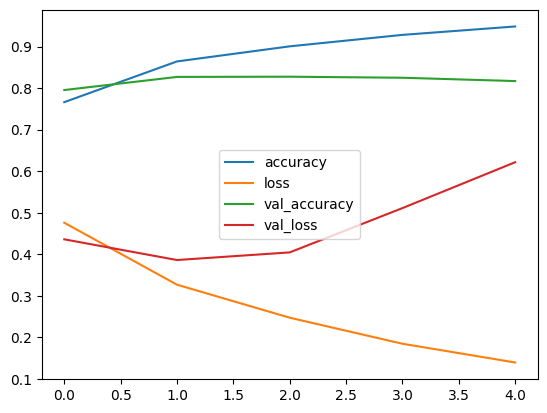

In [36]:
pd.DataFrame(history.history).plot()

This simple model is overfitted with training data as the validation loss increases.

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4976
           1       0.00      0.00      0.00      5024

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



c:\Users\Ort\miniconda3\envs\keras_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ort\miniconda3\envs\keras_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ort\miniconda3\envs\keras_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

<Axes: >

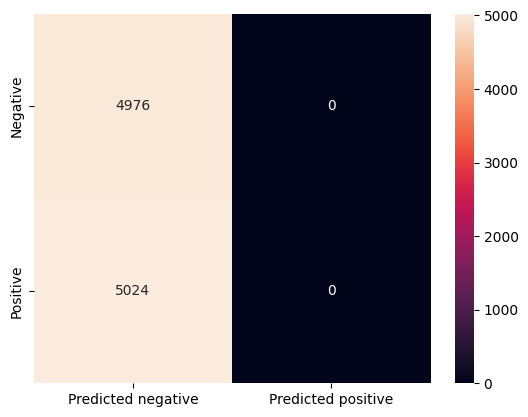

In [40]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

## Modified LSTM model

We added Dropout layers to prevent overfitting.

In [41]:
embed_size = 64
model_v2 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model_v2.summary()

c:\Users\Ort\miniconda3\envs\keras_env\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model_v2.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.5530 - loss: 0.6818 - val_accuracy: 0.7678 - val_loss: 0.5224
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.7833 - loss: 0.5339 - val_accuracy: 0.8112 - val_loss: 0.4541
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.8255 - loss: 0.4532 - val_accuracy: 0.8256 - val_loss: 0.4239
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.8463 - loss: 0.4057 - val_accuracy: 0.8289 - val_loss: 0.3961
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8572 - loss: 0.3765 - val_accuracy: 0.8255 - val_loss: 0.3896
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8711 - loss: 0.3506 - val_accuracy: 0.8324 - val_loss: 0.3820
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.8778 - loss: 0.3287 - val_accuracy: 0.8324 - val_loss: 0.3809
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.8819 - loss: 0.3171 - 

<AxesSubplot:>

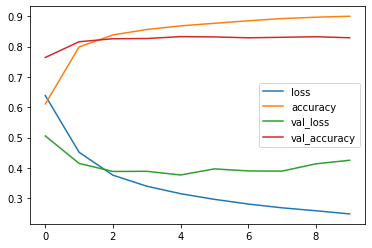

In [20]:
pd.DataFrame(history.history).plot()

Looks better than first model.

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4976
           1       0.00      0.00      0.00      5024

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



c:\Users\Ort\miniconda3\envs\keras_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ort\miniconda3\envs\keras_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ort\miniconda3\envs\keras_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

<Axes: >

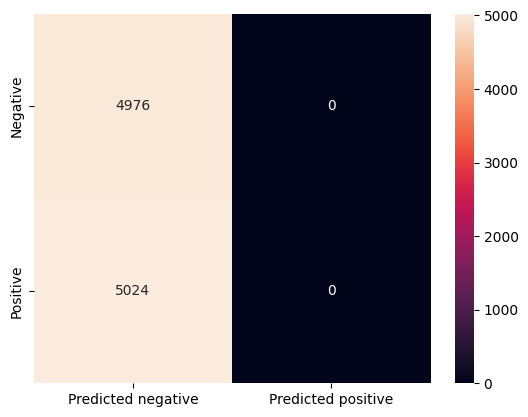

In [45]:
y_pred = model_v2.predict(X_test).argmax(-1)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

Use of full-sentences would increase accurcy. But it is time-consuming and seems difficult to overwhelm simple Logistic regression model.